# ML Answers

- **Answer Set**: No. 04
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [9]:
import numpy as np
import scipy.io as sp
import matplotlib.pyplot as plt

### Dataset

Now we can load our dataset:

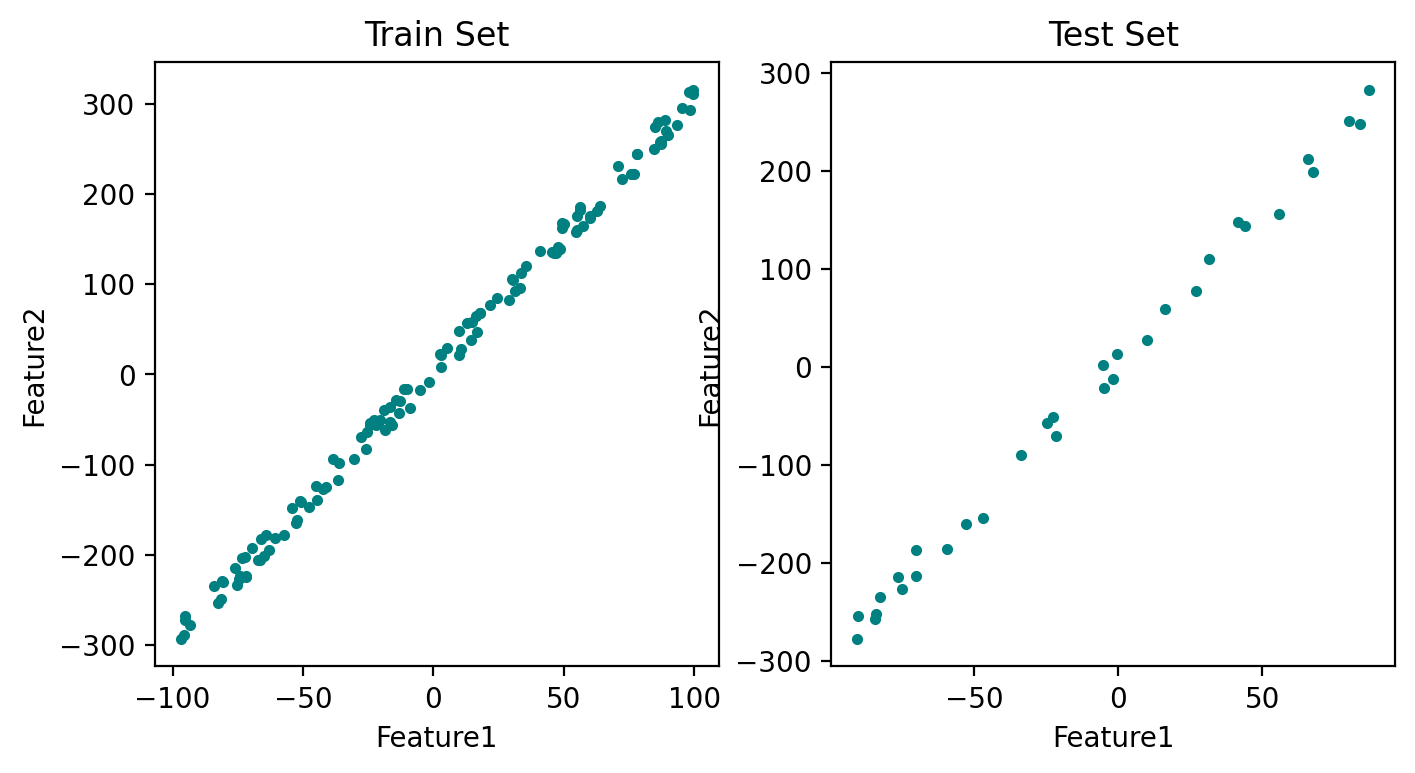

In [7]:
train_set = np.load("../lib/train_set.npy")
test_set = np.load("../lib/test_set.npy")

train_features = train_set[:, :]
test_features = test_set[:, :]

fig = plt.figure(figsize=(8, 4), dpi=200)

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(train_features.T[0], train_features.T[1], marker=".", c="teal")
ax1.set_title("Train Set")
ax1.set_xlabel("Feature1")
ax1.set_ylabel("Feature2")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(test_features.T[0], test_features.T[1], marker=".", c="teal")
ax2.set_title("Test Set")
ax2.set_xlabel("Feature1")
ax2.set_ylabel("Feature2")

plt.show()

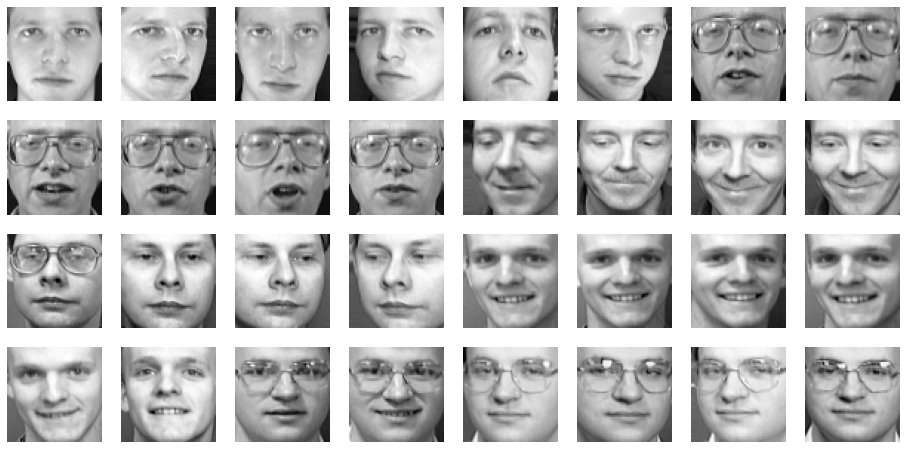

In [66]:
faces_set = sp.loadmat("../lib/faces.mat")["faces"].T

train_faces = faces_set[0:280, :]
test_faces = faces_set[280:-1, :]

faces_images = train_faces.reshape(280, 64, 64)

fig = plt.figure(figsize=(16, 8))

for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(faces_images[i * 8 + j].T, cmap="gray")
        ax.axis("off")

plt.show()


### Standardize

Now, we standardize our train, test features:

$$
\begin{aligned}
    & X_{standard} = \frac{X - \mu(X)}{\sqrt{Var(X)}}
\end{aligned}
$$

In [67]:
train_features = (train_features - np.mean(train_features)) / np.std(train_features)
test_features = (test_features - np.mean(test_features)) / np.std(test_features)

train_faces = (train_faces - np.mean(train_faces)) / np.std(train_faces)
test_faces = (test_faces - np.mean(test_faces)) / np.std(test_faces)

### Features Function

A useful function, that generates a feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree:

In [ ]:
def features_matrix(features, degree):
    features = features.T
    result = []

    for i in range(0, degree + 1):
        for coeffs in polynomial_coefficients(len(features), i, 0):
            terms = [np.power(features[index], coeff) for index, coeff in enumerate(coeffs)]
            result.append(np.prod(terms, axis=0))
    
    return np.array(result).T

def polynomial_coefficients(terms, degree, index):
    result = []

    if index == terms - 1:
        return [[degree]]

    for i in range(degree, -1, -1):
        for coeff in polynomial_coefficients(terms, degree - i, index + 1):
            result.append([i] + coeff)

    return result

---

## Problem (1)

### (1)

First we find the `Mean` ($\mu_i$) of each class:

$$
\begin{aligned}
    & \mu_1 = \frac{(
        \begin{bmatrix}0 \\ -1\end{bmatrix} +
        \begin{bmatrix}1 \\ 0\end{bmatrix} +
        \begin{bmatrix}2 \\ 1\end{bmatrix}
    )}{3} = \begin{bmatrix}1 \\ 0\end{bmatrix}
    \\
    \\
    & \mu_2 = \frac{(
        \begin{bmatrix}1 \\ 1\end{bmatrix} +
        \begin{bmatrix}-1 \\ 1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix}
    )}{4} = \begin{bmatrix}-0.5 \\ 0\end{bmatrix}
\end{aligned}
$$

### (2)

Now we find the `Within-Class Scatter Matrix` ($S_W$):

$$
\begin{aligned}
    & S_W = S_1 + S_2
    \\
    & S_1 = \sum_{x^{(i)} \in C_1} (x^{(i)} - \mu_1)(x^{(i)} - \mu_1)^T
    \\
    & S_2 = \sum_{x^{(i)} \in C_2} (x^{(i)} - \mu_2)(x^{(i)} - \mu_2)^T
    \\
    \\
    & S_W = \begin{bmatrix}
        5 & 4 \\
        4 & 6
    \end{bmatrix}
\end{aligned}
$$

### (3)

Now we find the `Between-Class Scatter Matrix` ($S_B$):

$$
\begin{aligned}
    & S_B = (\mu_1 - \mu_2)(\mu_1 - \mu_2)^T
    \\
    \\
    & S_B = \begin{bmatrix}
        \frac{9}{4} & 0 \\
        0 & 0
    \end{bmatrix}
\end{aligned}
$$

### (4)

Now we find the `Eigen Vector` related to `Maximum Eigen Value` of matrix $S_W^{-1} S_B$:

$$
\begin{aligned}
    & S_W^{-1} S_B = \begin{bmatrix}
        0.96 & 0 \\
        -0.64 & 0
    \end{bmatrix}
    \\
    & Eigvals(S_W^{-1} S_B) = \begin{bmatrix}0 \\ \frac{27}{28}\end{bmatrix}
    \\
    \\
    & V_{Max} = \begin{bmatrix}1 \\ -0.55\end{bmatrix}
\end{aligned}
$$

### Results

As we can see, **LD1** vector is equals to the `Eigen Vector` related to `Maximum Eigen Value` which is $\begin{bmatrix}1 \\ -0.55\end{bmatrix}$.

---